In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [2]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

import torch.nn as nn
import torch.optim as optim
import PIL

from sklearn.model_selection import train_test_split
from tqdm import tqdm, trange

In [3]:
# prompt: git copy this repo https://github.com/wenjie-liao/StructGAN_v1/tree/master/0_datasets

!git clone https://github.com/wenjie-liao/StructGAN_v1.git
!mv StructGAN_v1/0_datasets ./
!rm -rf StructGAN_v1

Cloning into 'StructGAN_v1'...
remote: Enumerating objects: 1900, done.
remote: Counting objects: 100% (1900/1900), done.
remote: Compressing objects: 100% (1501/1501), done.
remote: Total 1900 (delta 415), reused 1850 (delta 390), pack-reused 0 (from 0)
Receiving objects: 100% (1900/1900), 42.33 MiB | 31.34 MiB/s, done.
Resolving deltas: 100% (415/415), done.


In [4]:
data_path = "/content/0_datasets/L1_7/train_B"
results_path = "../data/results/L1_7"

# Data

In [5]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, data_path, transform=None):
        self.data_path = data_path
        self.transform = transform
        self.data = os.listdir(data_path)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img = PIL.Image.open(os.path.join(self.data_path, self.data[idx]))
        if self.transform:
            img = self.transform(img)
        return img

In [6]:
# Data loading and transformation, like flipping and adding noise
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.ToTensor(),
])


# Create a dataset for loading images
image_dataset = Dataset(data_path, transform=transform)

In [7]:
from sklearn.model_selection import train_test_split

# Assuming image_dataset is already defined and loaded with images
# Split the dataset into training and test sets (75% train, 25% test)
train_data, test_data = train_test_split(image_dataset, test_size=0.25)

# Further split the training data into training and validation sets (75% train, 25% validation)
train_data, val_data = train_test_split(train_data, test_size=0.25)

# Print the sizes of the datasets
print(f"Training data size: {len(train_data)}")
print(f"Validation data size: {len(val_data)}")
print(f"Test data size: {len(test_data)}")

# Create a DataLoader for each dataset
batch_size = 1
train_loader = DataLoader(train_data, batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size, shuffle=False)

print(f"Number of batches in train_loader: {len(train_loader)}")
print(f"Number of batches in val_loader: {len(val_loader)}")
print(f"Number of batches in test_loader: {len(test_loader)}")

Training data size: 30
Validation data size: 11
Test data size: 14
Number of batches in train_loader: 30
Number of batches in val_loader: 11
Number of batches in test_loader: 14


In [8]:
image_size = 3 * 1024 * 2048  # Total number of elements in the image

# Model

## Pix2Pix

In [9]:
import torch
import torch.nn as nn

class UNetGenerator(nn.Module):
    def __init__(self, in_channels=3, out_channels=3):
        super(UNetGenerator, self).__init__()

        def conv_block(in_channels, out_channels, kernel_size=3, stride=1, padding=1):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True)
            )

        def upconv_block(in_channels, out_channels, kernel_size=3, stride=1, padding=1):
            return nn.Sequential(
                nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
                nn.Conv2d(out_channels, out_channels, kernel_size, stride, padding),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True)
            )

        self.encoder1 = conv_block(in_channels, 64)
        self.encoder2 = conv_block(64, 128)
        self.encoder3 = conv_block(128, 256)
        self.encoder4 = conv_block(256, 512)
        self.encoder5 = conv_block(512, 1024)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.upconv4 = upconv_block(1024, 512)
        self.upconv3 = upconv_block(1024, 256)
        self.upconv2 = upconv_block(512, 128)
        self.upconv1 = upconv_block(256, 64)  # Corrected input channels

        self.final_conv = nn.Conv2d(128, out_channels, kernel_size=1)  # Corrected input channels

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool(enc1))
        enc3 = self.encoder3(self.pool(enc2))
        enc4 = self.encoder4(self.pool(enc3))
        enc5 = self.encoder5(self.pool(enc4))

        dec4 = self.upconv4(enc5)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)

        return self.final_conv(dec1)

In [10]:
class PatchGANDiscriminator(nn.Module):
    def __init__(self, in_channels=3):
        super(PatchGANDiscriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels * 2, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, kernel_size=4, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=1)
        )

    def forward(self, x, y):
        x = torch.cat([x, y], dim=1)
        return self.model(x)


In [11]:
# Test the fixed code
X = torch.rand(1, 3, 1024, 2048)
generator = UNetGenerator()
discriminator = PatchGANDiscriminator()

fake_image = generator(X)
discriminator_output = discriminator(fake_image, X)
print(f"Generator output shape: {fake_image.shape}")
print(f"Discriminator output shape: {discriminator_output.shape}")

Generator output shape: torch.Size([1, 3, 1024, 2048])
Discriminator output shape: torch.Size([1, 1, 126, 254])


## GAN

In [12]:
import torch
import torch.nn as nn

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(True)
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [13]:
import torch
import torch.nn as nn

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1024, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(1024, 1, kernel_size=4, stride=1, padding=0),
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(1*29*61, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x)
        return x

In [14]:
# Initialize the models
generator = Generator()
discriminator = Discriminator()

In [15]:
X = torch.randn(1, 3, 1024, 2048)
out = generator(X)
print(f"Generator shape: {out.shape}")
out = discriminator(out)
print(f"Discriminator shape: {out.shape}")
print(f"Discriminator output: {out}")
loss_fn = nn.BCELoss()
loss = loss_fn(out, torch.zeros(1, 1))
print(f"Loss: {loss}")

Generator shape: torch.Size([1, 3, 1024, 2048])
Discriminator shape: torch.Size([1, 1])
Discriminator output: tensor([[0.4446]], grad_fn=<SigmoidBackward0>)
Loss: 0.5880155563354492


# Model

## Training

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import trange
import matplotlib.pyplot as plt

# Assuming UNetGenerator and PatchGANDiscriminator are already defined

def train(generator, discriminator, train_loader, val_loader, num_epochs=50, lr=0.0002):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    generator.to(device)
    discriminator.to(device)

    criterion_GAN = nn.BCEWithLogitsLoss()
    criterion_L1 = nn.L1Loss()

    optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

    train_losses_G = []
    train_losses_D = []
    val_losses_G = []
    val_losses_D = []

    for epoch in trange(num_epochs, desc="Epochs"):
        generator.train()
        discriminator.train()

        epoch_loss_G = 0
        epoch_loss_D = 0

        for real_images in train_loader:
            real_images = real_images.to(device)
            fake_images = generator(real_images)

            # Train Discriminator
            optimizer_D.zero_grad()
            real_labels = torch.ones(real_images.size(0), 1, 126, 254).to(device)
            fake_labels = torch.zeros(real_images.size(0), 1, 126, 254).to(device)

            real_output = discriminator(real_images, real_images)
            fake_output = discriminator(fake_images.detach(), real_images)

            loss_D_real = criterion_GAN(real_output, real_labels)
            loss_D_fake = criterion_GAN(fake_output, fake_labels)
            loss_D = (loss_D_real + loss_D_fake) / 2
            loss_D.backward()
            optimizer_D.step()

            # Train Generator
            optimizer_G.zero_grad()
            fake_output = discriminator(fake_images, real_images)
            loss_G_GAN = criterion_GAN(fake_output, real_labels)
            loss_G_L1 = criterion_L1(fake_images, real_images)
            loss_G = loss_G_GAN + 100 * loss_G_L1
            loss_G.backward()
            optimizer_G.step()

            epoch_loss_G += loss_G.item()
            epoch_loss_D += loss_D.item()

        train_losses_G.append(epoch_loss_G / len(train_loader))
        train_losses_D.append(epoch_loss_D / len(train_loader))

        val_loss_G, val_loss_D = validate(generator, discriminator, val_loader, criterion_GAN, criterion_L1, device)
        val_losses_G.append(val_loss_G)
        val_losses_D.append(val_loss_D)

    plot_losses(train_losses_G, train_losses_D, val_losses_G, val_losses_D)


In [17]:
def validate(generator, discriminator, val_loader, criterion_GAN, criterion_L1, device):
    generator.eval()
    discriminator.eval()

    val_loss_G = 0
    val_loss_D = 0

    with torch.no_grad():
        for real_images in val_loader:
            real_images = real_images.to(device)
            fake_images = generator(real_images)

            real_labels = torch.ones(real_images.size(0), 1, 126, 254).to(device)
            fake_labels = torch.zeros(real_images.size(0), 1, 126, 254).to(device)

            real_output = discriminator(real_images, real_images)
            fake_output = discriminator(fake_images, real_images)

            loss_D_real = criterion_GAN(real_output, real_labels)
            loss_D_fake = criterion_GAN(fake_output, fake_labels)
            loss_D = (loss_D_real + loss_D_fake) / 2

            fake_output = discriminator(fake_images, real_images)
            loss_G_GAN = criterion_GAN(fake_output, real_labels)
            loss_G_L1 = criterion_L1(fake_images, real_images)
            loss_G = loss_G_GAN + 100 * loss_G_L1

            val_loss_G += loss_G.item()
            val_loss_D += loss_D.item()

    return val_loss_G / len(val_loader), val_loss_D / len(val_loader)


In [18]:

def test(generator, discriminator, test_loader, criterion_GAN, criterion_L1, device):
    generator.eval()
    discriminator.eval()

    test_loss_G = 0
    test_loss_D = 0

    with torch.no_grad():
        for real_images in test_loader:
            real_images = real_images.to(device)
            fake_images = generator(real_images)

            real_labels = torch.ones(real_images.size(0), 1, 126, 254).to(device)
            fake_labels = torch.zeros(real_images.size(0), 1, 126, 254).to(device)

            real_output = discriminator(real_images, real_images)
            fake_output = discriminator(fake_images, real_images)

            loss_D_real = criterion_GAN(real_output, real_labels)
            loss_D_fake = criterion_GAN(fake_output, fake_labels)
            loss_D = (loss_D_real + loss_D_fake) / 2

            fake_output = discriminator(fake_images, real_images)
            loss_G_GAN = criterion_GAN(fake_output, real_labels)
            loss_G_L1 = criterion_L1(fake_images, real_images)
            loss_G = loss_G_GAN + 100 * loss_G_L1

            test_loss_G += loss_G.item()
            test_loss_D += loss_D.item()

    return test_loss_G / len(test_loader), test_loss_D / len(test_loader)


In [19]:
def plot_losses(train_losses_G, train_losses_D, val_losses_G, val_losses_D):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses_G, label='Train Generator Loss')
    plt.plot(train_losses_D, label='Train Discriminator Loss')
    plt.plot(val_losses_G, label='Validation Generator Loss')
    plt.plot(val_losses_D, label='Validation Discriminator Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


In [20]:
torch.cuda.empty_cache()

Device: cuda


Epochs: 100%|██████████| 50/50 [18:54<00:00, 22.68s/it]


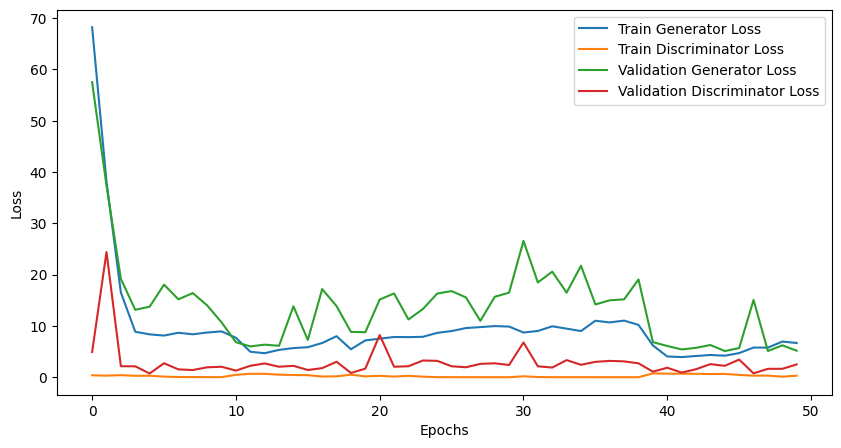

Test Generator Loss: 6.1220443078449795, Test Discriminator Loss: 1.8893557701792036


In [21]:
# Example usage
# Assuming train_loader, val_loader, and test_loader are defined
generator = UNetGenerator()
discriminator = PatchGANDiscriminator()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")
generator.to(device)
discriminator.to(device)

train(generator, discriminator, train_loader, val_loader, num_epochs=50, lr=0.0002)
test_loss_G, test_loss_D = test(generator, discriminator, test_loader, nn.BCEWithLogitsLoss(), nn.L1Loss(), device)
print(f"Test Generator Loss: {test_loss_G}, Test Discriminator Loss: {test_loss_D}")

# Check result

In [26]:
dataset = Dataset(data_path, transform=transforms.ToTensor())

# Create a DataLoader for the dataset
batch_size = 1
test_loader = DataLoader(dataset, batch_size, shuffle=False)

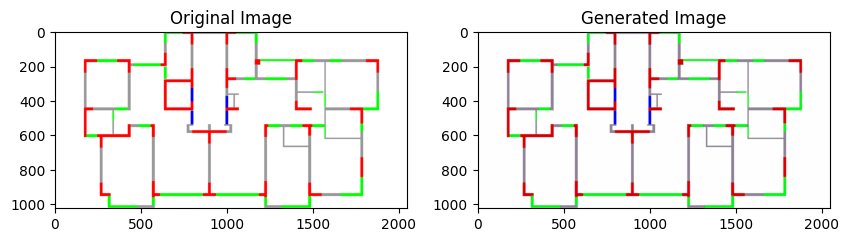

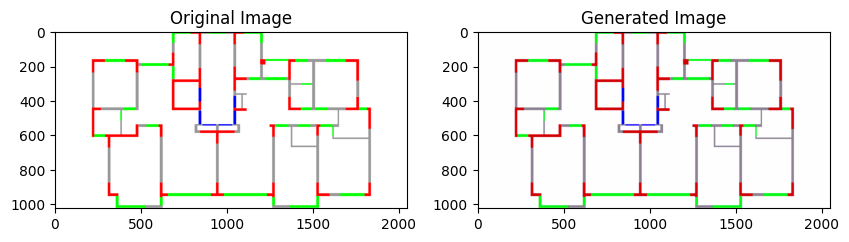

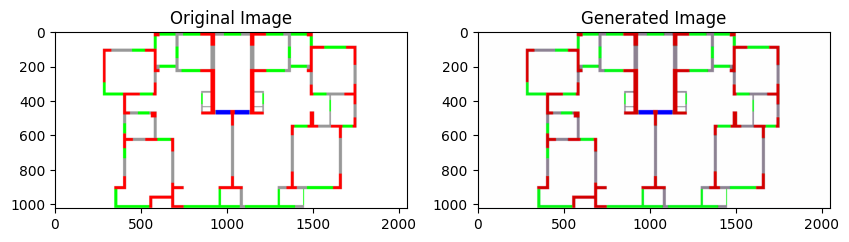

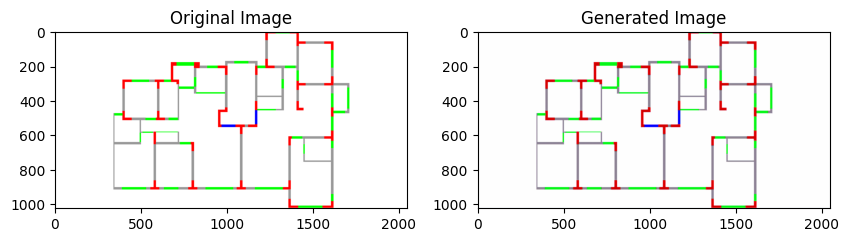

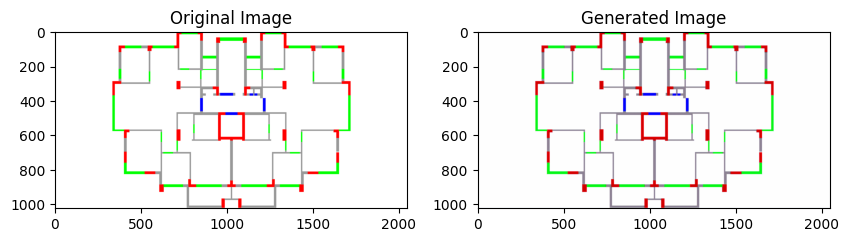

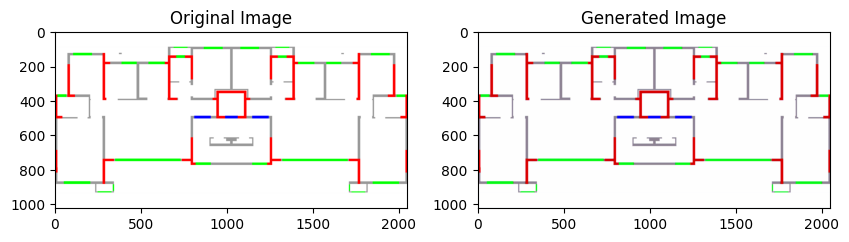

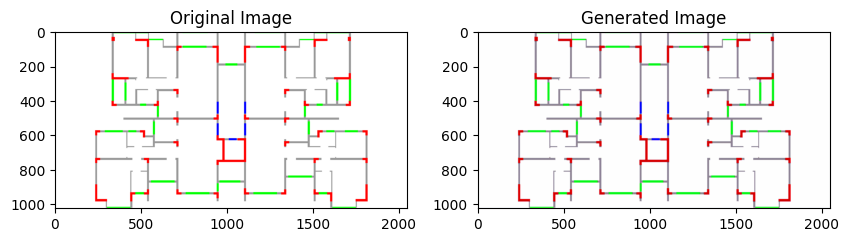

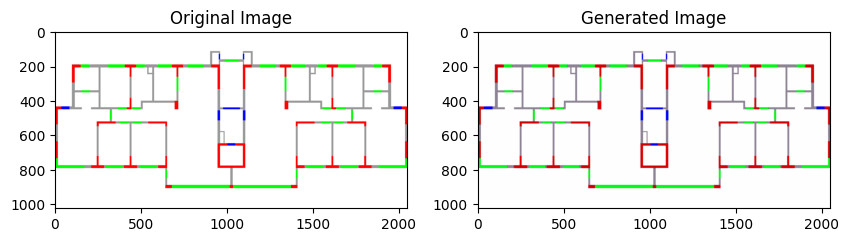

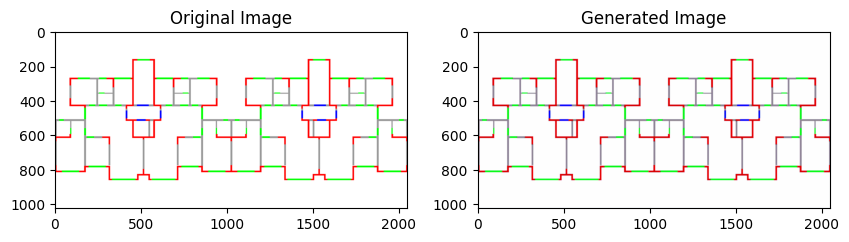

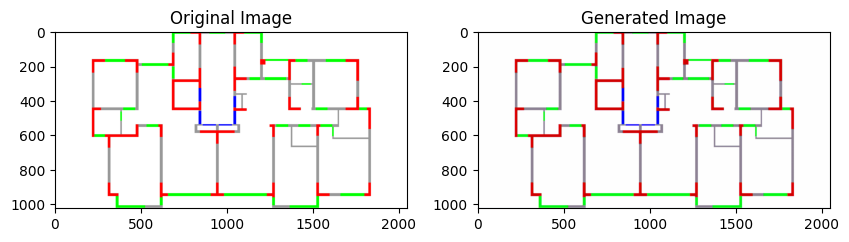

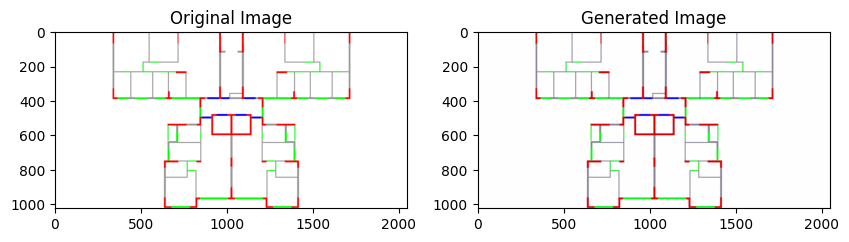

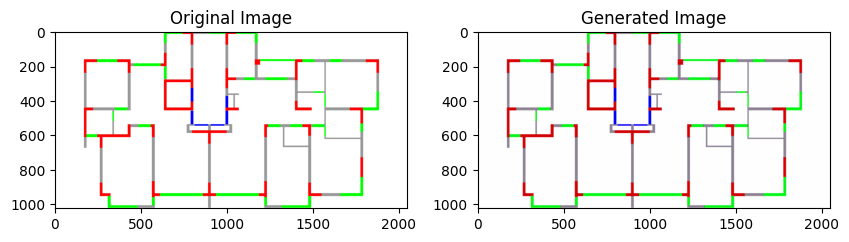

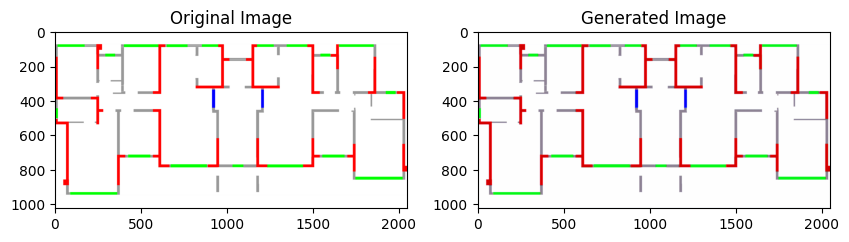

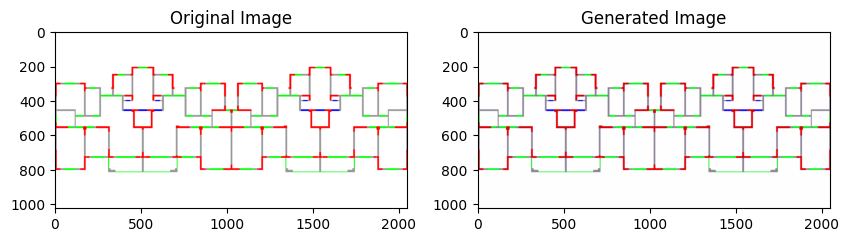

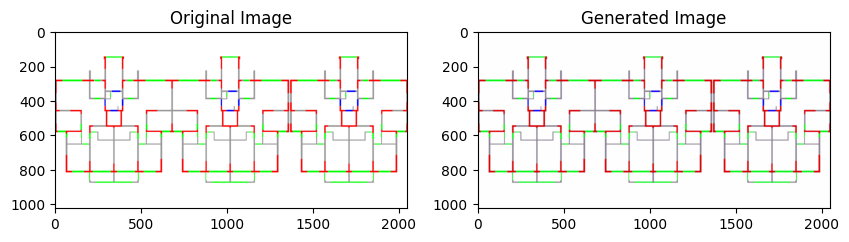

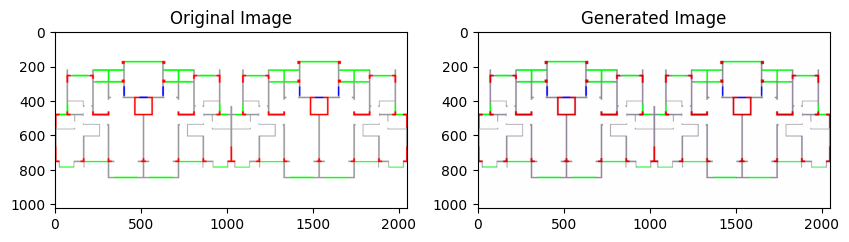

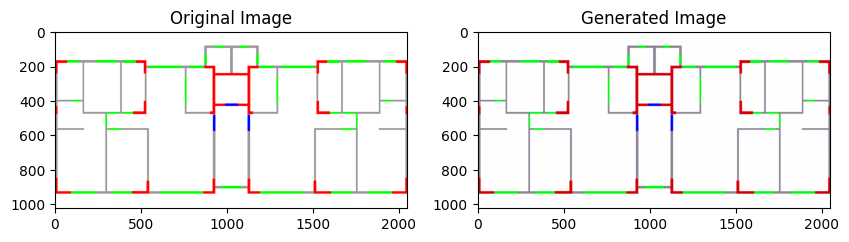

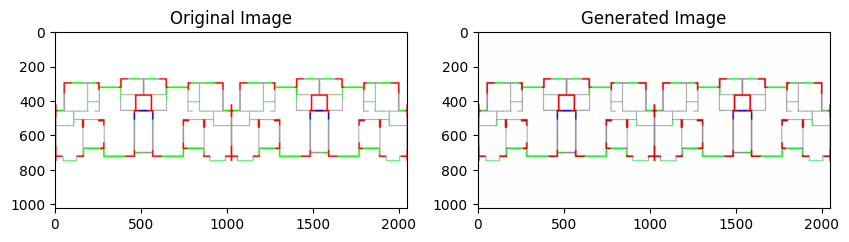

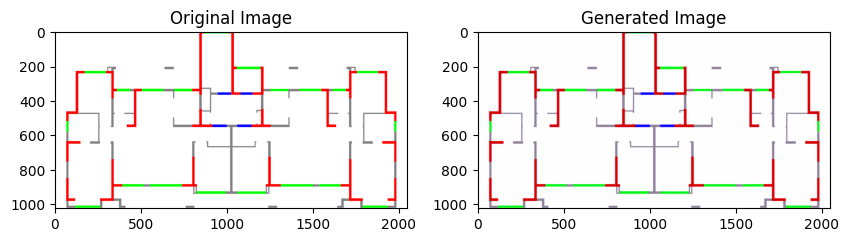

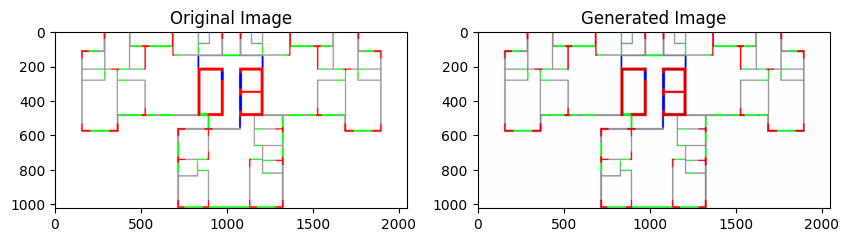

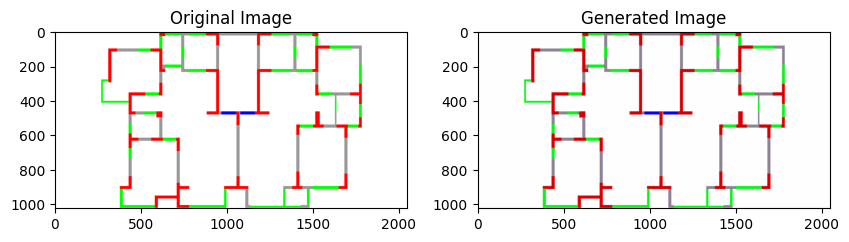

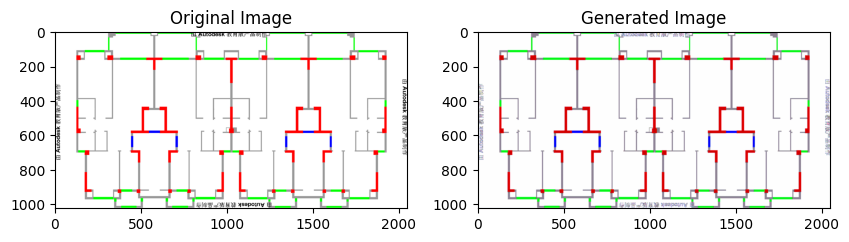

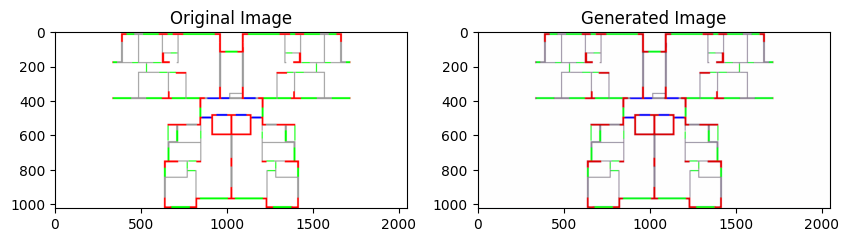

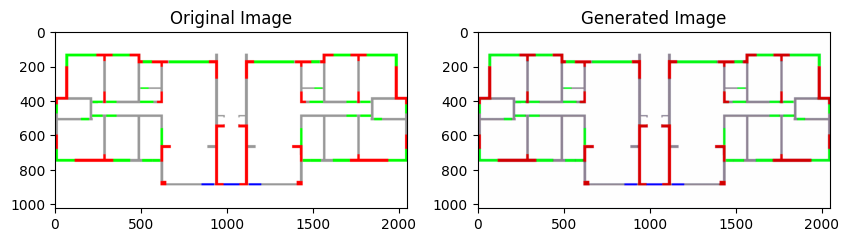

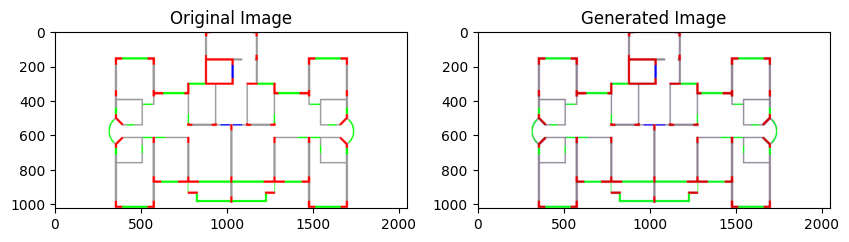

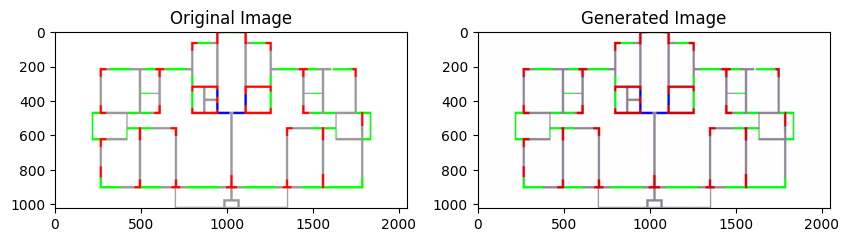

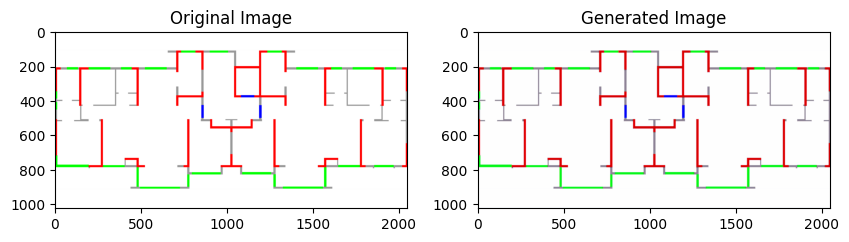

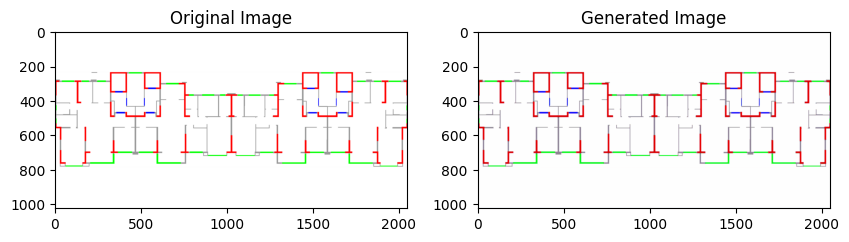

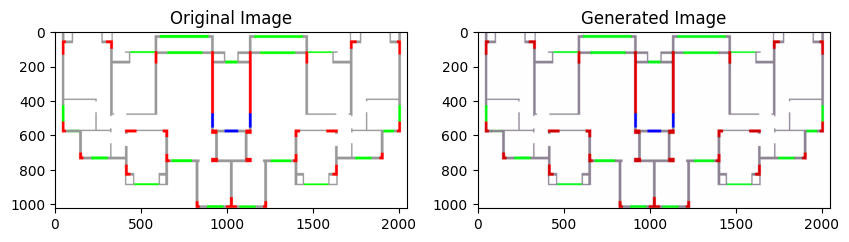

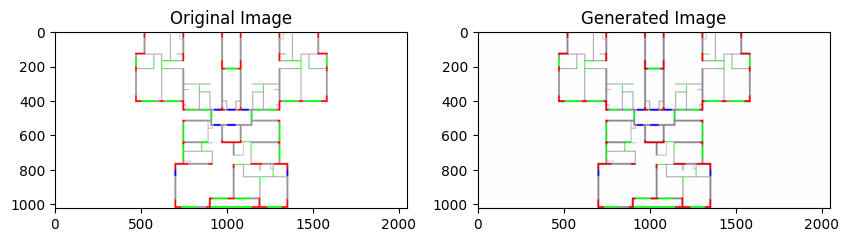

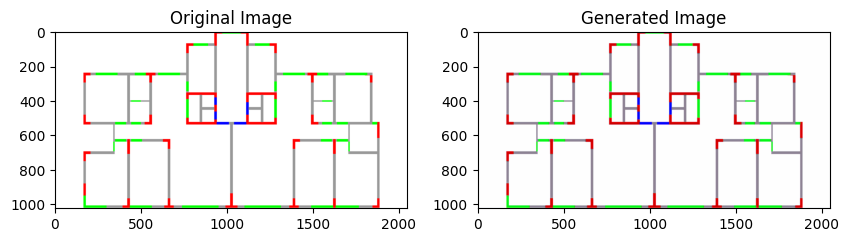

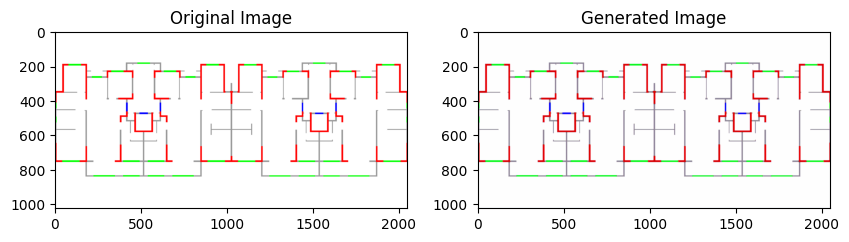

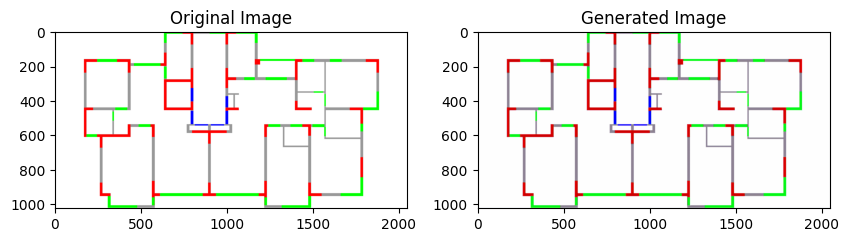

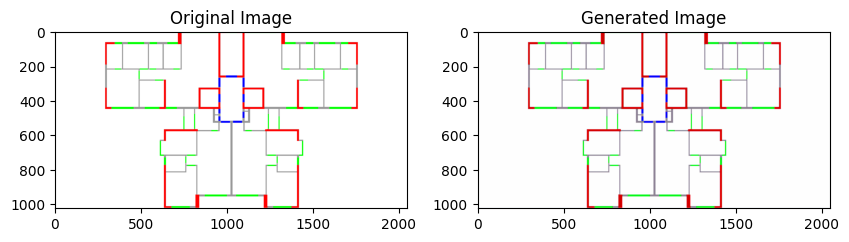

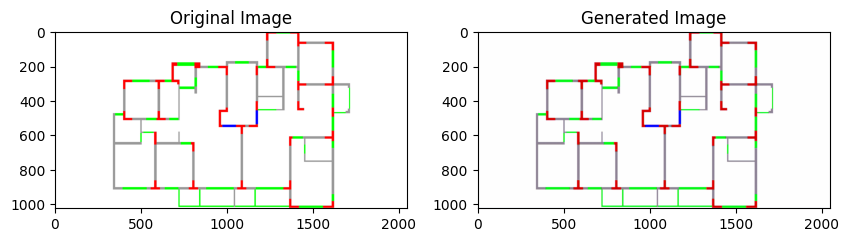

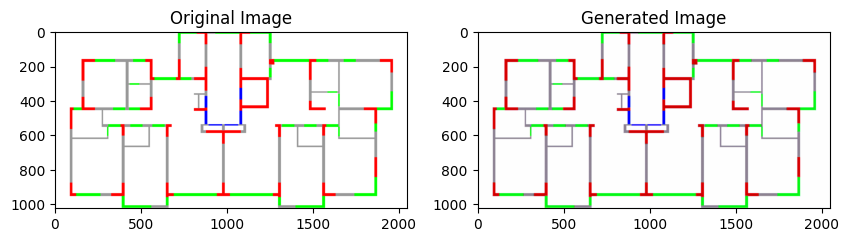

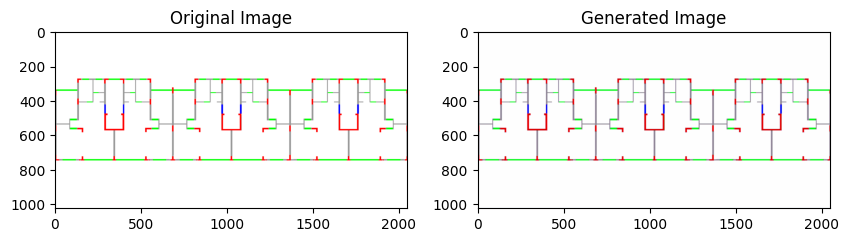

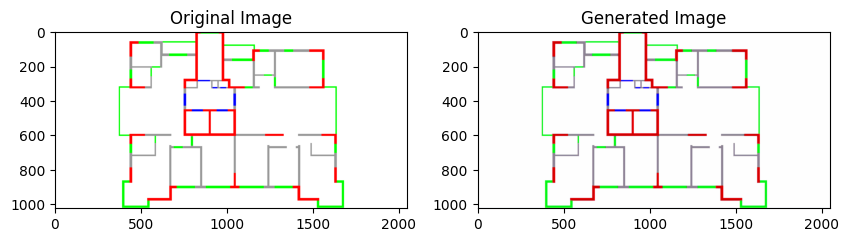

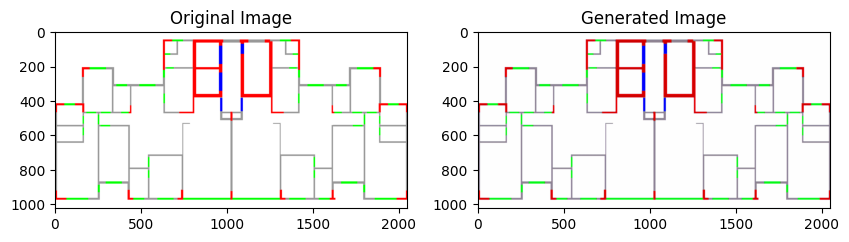

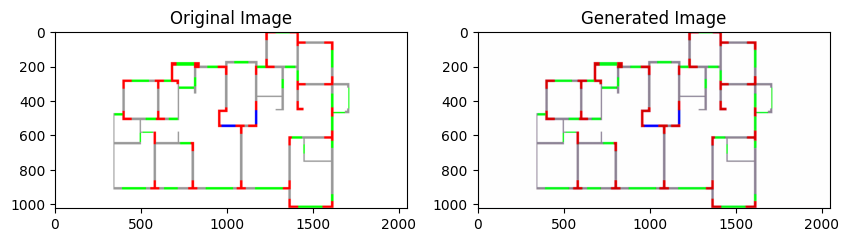

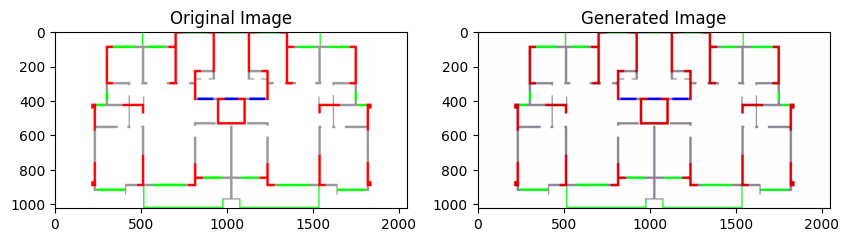

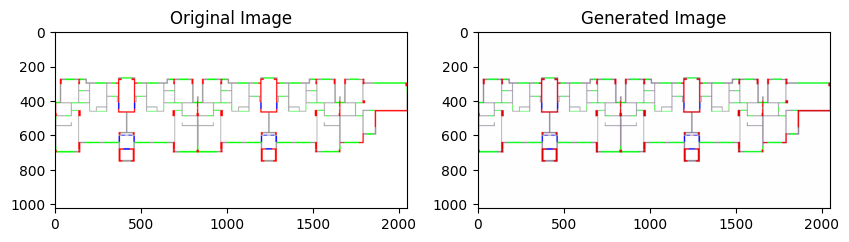

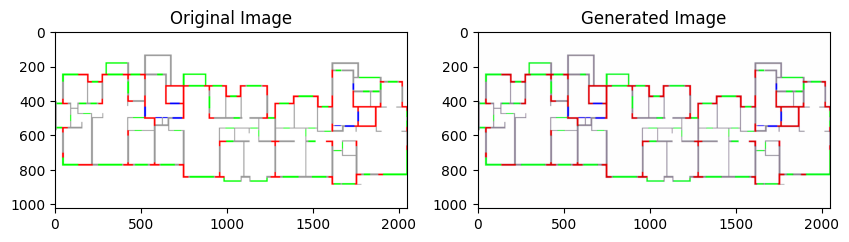

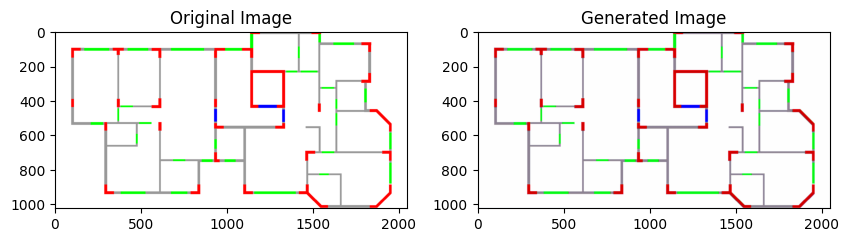

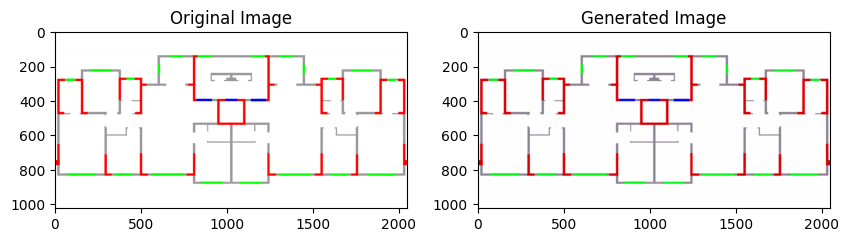

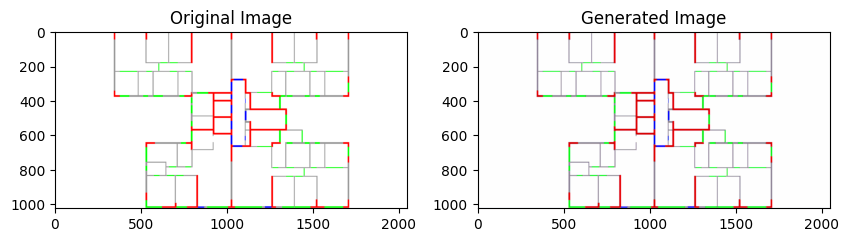

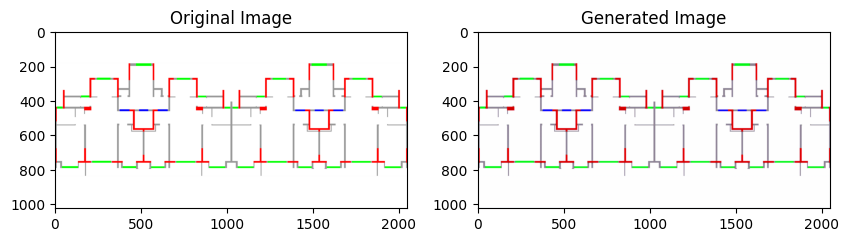

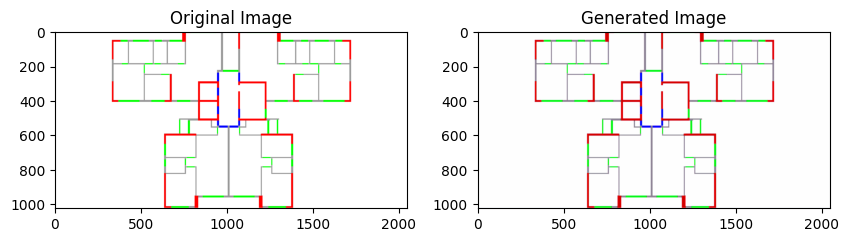

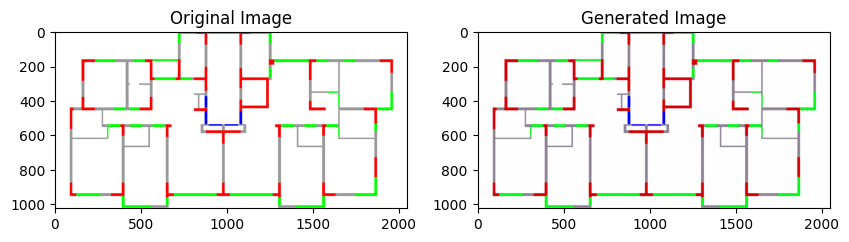

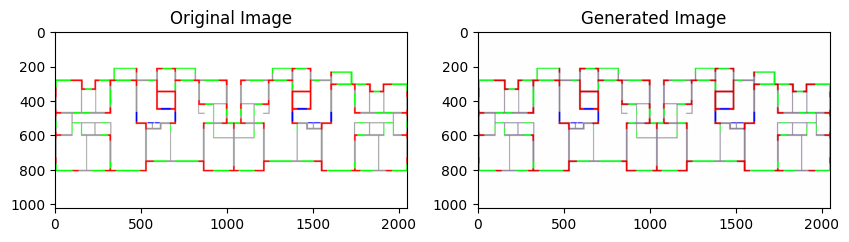

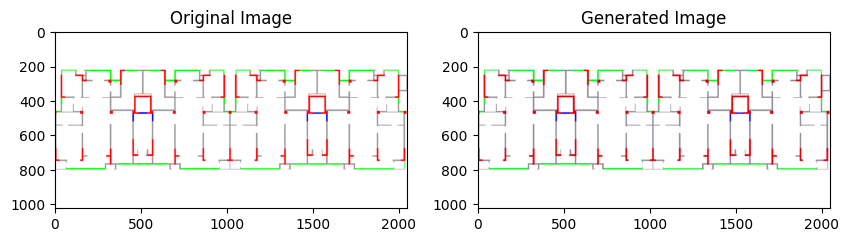

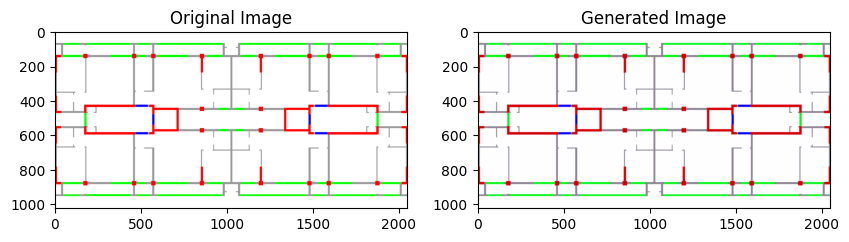

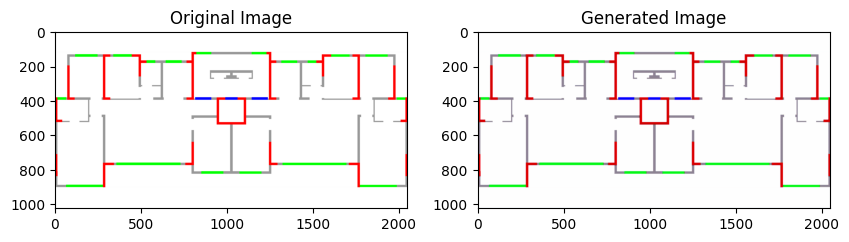

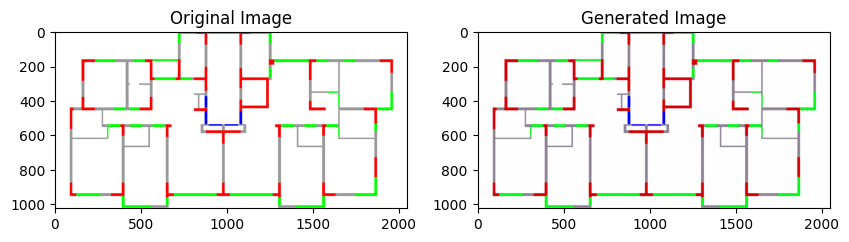

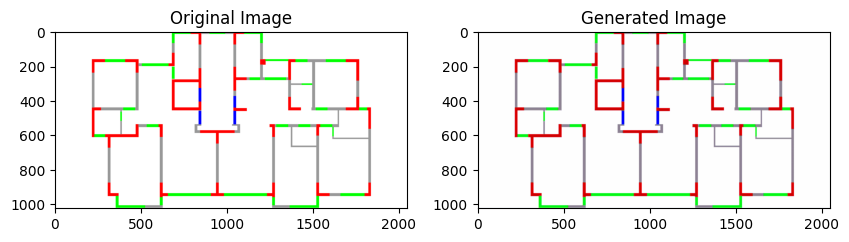

In [27]:
# prompt: based on generator, input an image and show the results

def image_generator(test_loader, generator, device):
  """
  Generates and displays images using the generator model.

  Args:
    test_loader: DataLoader for the test set.
    generator: The generator model.
    device: The device (CPU or GPU) to use for computations.
  """
  generator.eval()  # Set the model to evaluation mode

  with torch.no_grad():  # Disable gradient calculations
    for real_images in test_loader:
      real_images = real_images.to(device)
      fake_images = generator(real_images)

      # Display the original and generated images
      plt.figure(figsize=(10, 5))
      plt.subplot(1, 2, 1)
      plt.imshow(np.transpose(real_images[0].cpu().numpy(), (1, 2, 0)))  # Assuming batch size is 1
      plt.title("Original Image")

      plt.subplot(1, 2, 2)
      plt.imshow(np.transpose(fake_images[0].cpu().numpy(), (1, 2, 0)))  # Assuming batch size is 1
      plt.title("Generated Image")

      plt.show()
      yield fake_images  # Yield the generated images (optional)


# Example usage:
# Assuming generator, test_loader, and device are already defined
for generated_images in image_generator(test_loader, generator, device):
  # You can process the generated_images here, e.g., save them to a file
  pass